# Task 6 : 评估分类效果
1. 使用COAP和SSPE方法计算Attack score
2. 使用Attack score做为标签，训练模型
3. 对模型输出的Attack score进行二值化，将流量划分为正常和攻击流量
4. 分别对比原始的Session、COAP和SSPE方法，提高噪音比例，观察模型的下降
6. Session方式下降最多，COAP和SSPE差别不大
7. 这里只负责展现，数据处理由./common/IoTMLEvaluate.py完成

In [332]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from Config import g_data_root
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
warnings.simplefilter("ignore")
g_token_root = "%stoken/"%g_data_root
g_feature_root = "%s/features"%g_data_root
g_result_root = "%sresult"%g_data_root

In [361]:
def show_total(df_result):
    df_tmp = df_result
    df_long = pd.melt(df_tmp,id_vars=['model'],value_vars=['recall', 'precision','accuracy','f1_score'],var_name='metric', value_name='value')
    sns.barplot(x='metric', y='value',hue='model',orient='v',ci=None,data=df_long)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
    plt.xlabel('Metric', fontsize=10)
    plt.ylabel('Metric value', fontsize=10)
    plt.title('Performance', fontsize=12)
    plt.show()
    
def show_bar(attack,df_tmp,hue):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.barplot(x='ratio', y='recall',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[0,0])
    sns.barplot(x='ratio', y='precision',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[0,1])
    sns.barplot(x='ratio', y='accuracy',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[1,0])
    sns.barplot(x='ratio', y='f1_score',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[1,1])
    axes[0,0].set_title("Recall")
    axes[0,0].set_xlabel('Noise ratio', fontsize=10)
    axes[0,0].set_ylabel('Metric value', fontsize=10)
    axes[0,1].set_title("Precision")
    axes[0,1].set_xlabel('Noise ratio', fontsize=10)
    axes[0,1].set_ylabel('Metric value', fontsize=10)
    axes[1,0].set_title("Accuracy")
    axes[1,0].set_xlabel('Noise ratio', fontsize=10)
    axes[1,0].set_ylabel('Metric value', fontsize=10)
    axes[1,1].set_title("F1_score")
    axes[1,1].set_xlabel('Noise ratio', fontsize=10)
    axes[1,1].set_ylabel('Metric value', fontsize=10)
    
    if len( axes[0,0].legend().get_texts()) == 1:
        axes[0,0].legend().set_visible(False) 
    if len( axes[0,1].legend().get_texts()) == 1:
        axes[0,1].legend().set_visible(False) 
    if len( axes[1,0].legend().get_texts()) == 1:
        axes[1,0].legend().set_visible(False) 
    if len( axes[1,1].legend().get_texts()) == 1:
        axes[1,1].legend().set_visible(False)

    axes[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.tight_layout()
    plt.show()
    
def show_line(attack,df_tmp,hue):
    fig, axes = plt.subplots(2, 2, figsize=(14, 6))
    sns.lineplot(x='ratio', y='recall',hue=hue,ci=None,data=df_tmp,ax=axes[0,0])
    sns.lineplot(x='ratio', y='precision',hue=hue,ci=None,data=df_tmp,ax=axes[0,1])
    sns.lineplot(x='ratio', y='accuracy',hue=hue,ci=None,data=df_tmp,ax=axes[1,0])
    sns.lineplot(x='ratio', y='f1_score',hue=hue,ci=None,data=df_tmp,ax=axes[1,1])
    axes[0,0].set_title("Recall")
    axes[0,0].set_xlabel('Noise ratio', fontsize=10)
    axes[0,0].set_ylabel('Metric value', fontsize=10)
    axes[0,1].set_title("Precision")
    axes[0,1].set_xlabel('Noise ratio', fontsize=10)
    axes[0,1].set_ylabel('Metric value', fontsize=10)
    axes[1,0].set_title("Accuracy")
    axes[1,0].set_xlabel('Noise ratio', fontsize=10)
    axes[1,0].set_ylabel('Metric value', fontsize=10)
    axes[1,1].set_title("F1_score")
    axes[1,1].set_xlabel('Noise ratio', fontsize=10)
    axes[1,1].set_ylabel('Metric value', fontsize=10)
    
    axes[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    if len( axes[0,0].legend().get_texts()) == 1:
        axes[0,0].legend().set_visible(False) 
    if len( axes[0,1].legend().get_texts()) == 1:
        axes[0,1].legend().set_visible(False) 
    if len( axes[1,0].legend().get_texts()) == 1:
        axes[1,0].legend().set_visible(False) 
    if len( axes[1,1].legend().get_texts()) == 1:
        axes[1,1].legend().set_visible(False)
    plt.tight_layout()
    plt.show()

In [362]:
df_session = pd.read_csv("./IIoTSet/result/ML-performance/task-1/performance.csv",index_col=0)
df_session['kind'] = "Session"
df_packet = pd.read_csv("./IIoTSet/result/ML-performance/task-6/classify.csv",index_col=0)
df_result = pd.concat([df_session,df_packet],ignore_index=True).reset_index(drop=True)
df_result = df_result[df_result['kind']!='Label']
df_result = df_result[df_result['kind']!='Other']
df_result['kind']=df_result['kind'].map({"Level":"SSPE","Level_Sum":"COAP","Session":"Session"})
del df_result['confusion_matrix']
df_result['ratio'] = (df_result['ratio']*100).astype(int)
df_result['ratio'] = df_result['ratio']/100
#df_result = df_result[~(df_result['model']=='bayes')].reset_index(drop=True)
#df_result = df_result[~(df_result['model']=='glm')].reset_index(drop=True)
#df_result = df_result[~(df_result['model']=='dt')].reset_index(drop=True)
#df_result = df_result[~(df_result['model']=='svm')].reset_index(drop=True)

# 原始的Session方式

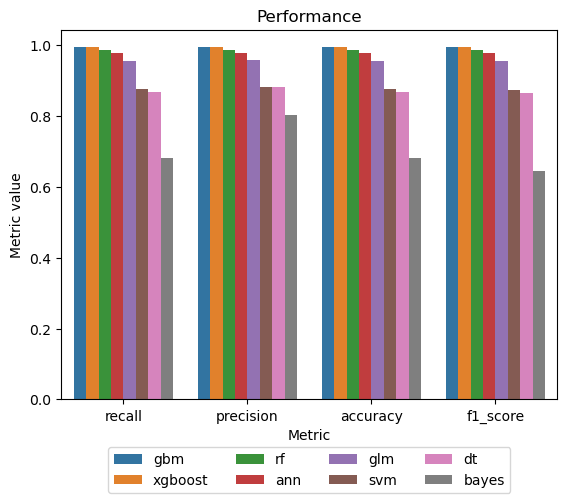

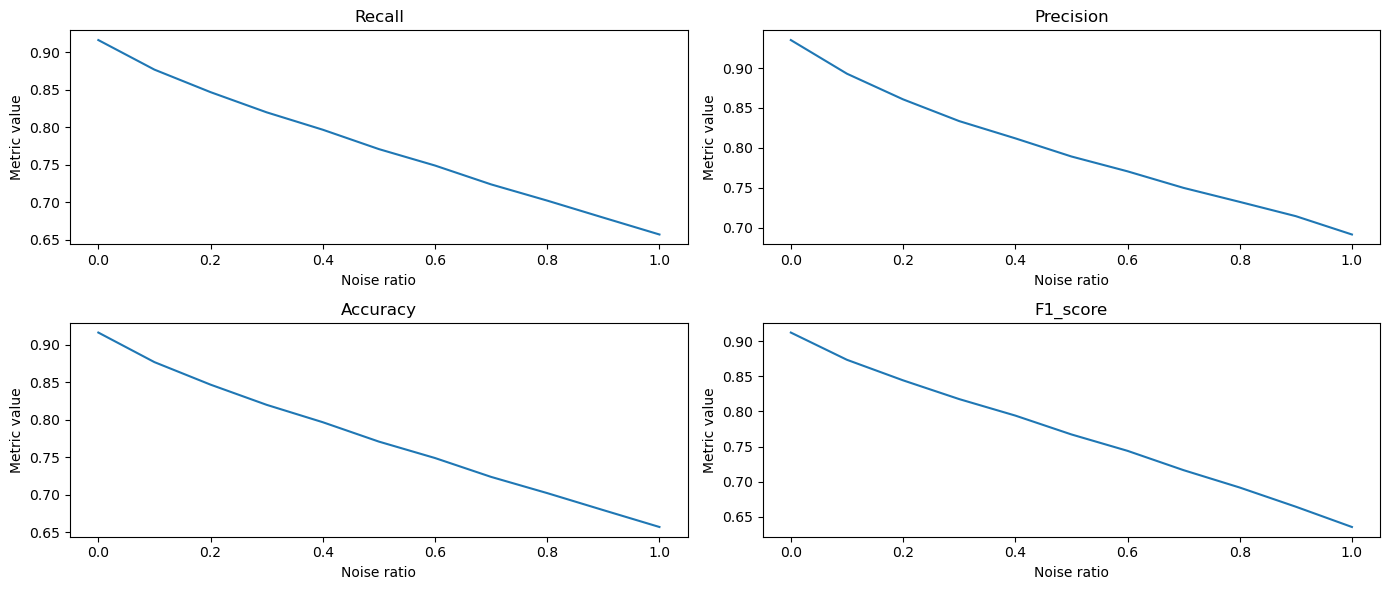

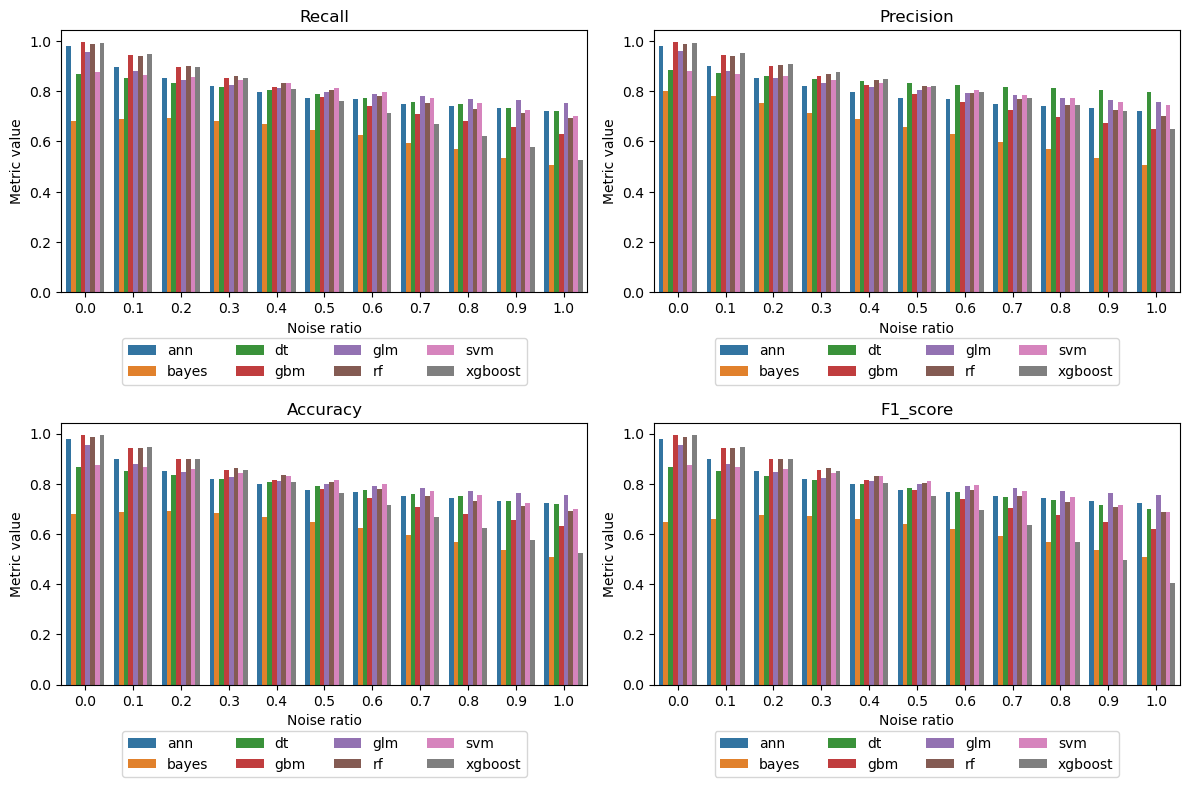

In [363]:
# 不加噪音
df_tmp = df_result[df_result['kind']=='Session'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)

# 加噪音模型的平均性能
df_tmp = df_result[df_result['kind']=='Session'].reset_index(drop=True)
del df_tmp['attack']
del df_tmp['model']
df_tmp = df_tmp.groupby(['kind','ratio']).mean().reset_index()
show_line("All",df_tmp,"kind")

#加噪音不同模型的性能
df_tmp = df_result[df_result['kind']=='Session'].reset_index(drop=True)
del df_tmp['attack']
df_tmp = df_tmp.groupby(['model','kind','ratio']).mean().reset_index()
show_bar("All",df_tmp,"model")

# 使用COAP和SSPE

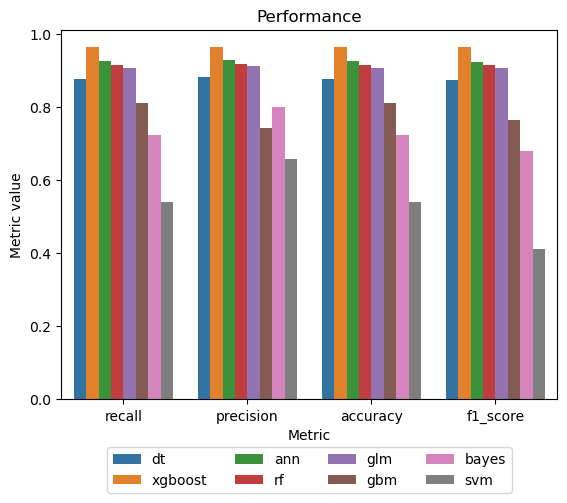

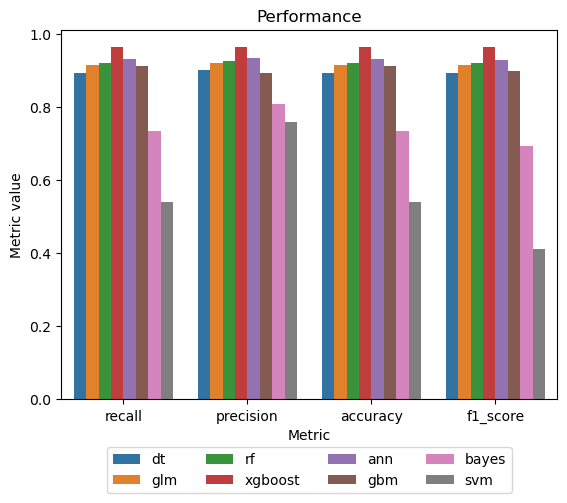

,recall,mcc,accuracy,precision,auc,f1_score,fbeta_score,ratio
kind,,,,,,,,
COAP,0.76832704,0.55796383,0.76832704,0.75836928,0.77041194,0.73362122,0.73396606,0.50000000
SSPE,0.78167275,0.58556625,0.78167275,0.78130292,0.78283615,0.74933863,0.75192777,0.50000000
Session,0.77628328,0.57296214,0.77628328,0.79850122,0.77679300,0.76915853,0.77962887,0.50000000


In [369]:
# COAP不加噪音
df_tmp = df_result[df_result['kind']=='COAP'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)
# SSPE 不加噪音
df_tmp = df_result[df_result['kind']=='SSPE'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)
df_tmp = df_result.copy(deep=True)
del df_tmp['model']
del df_tmp['attack']
#加噪音的平均性能
df_tmp = df_tmp.groupby(['kind']).mean()
df_tmp

# Session，COAP和SSPE的对比

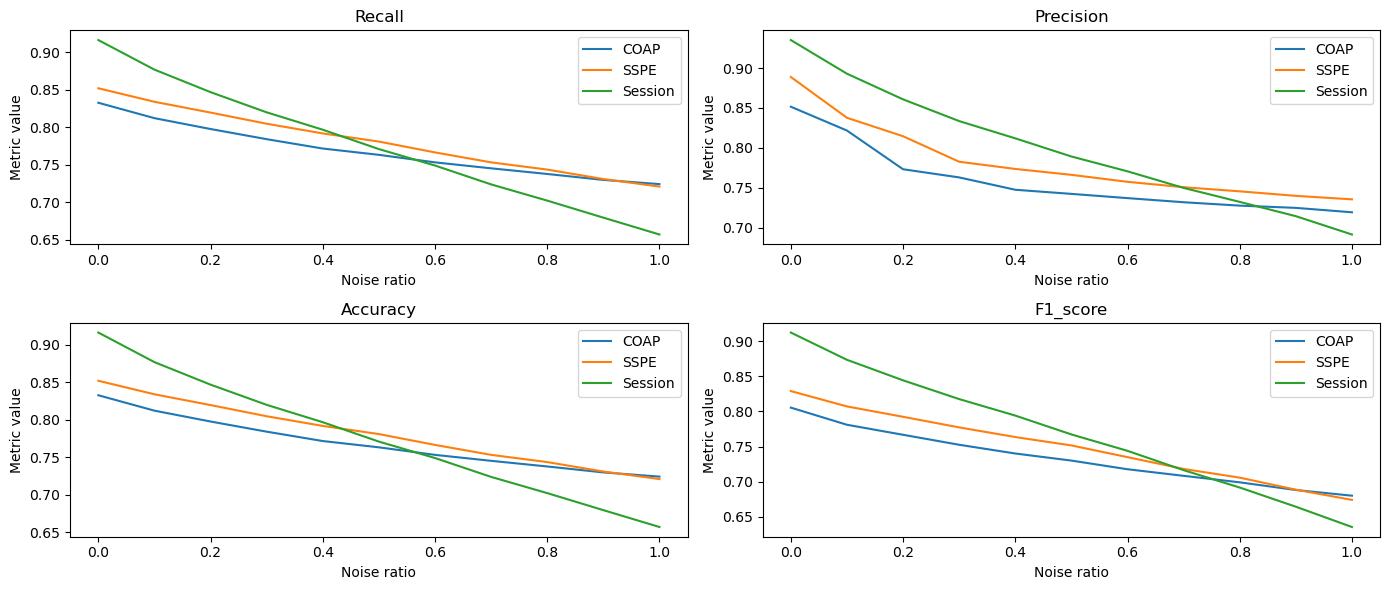

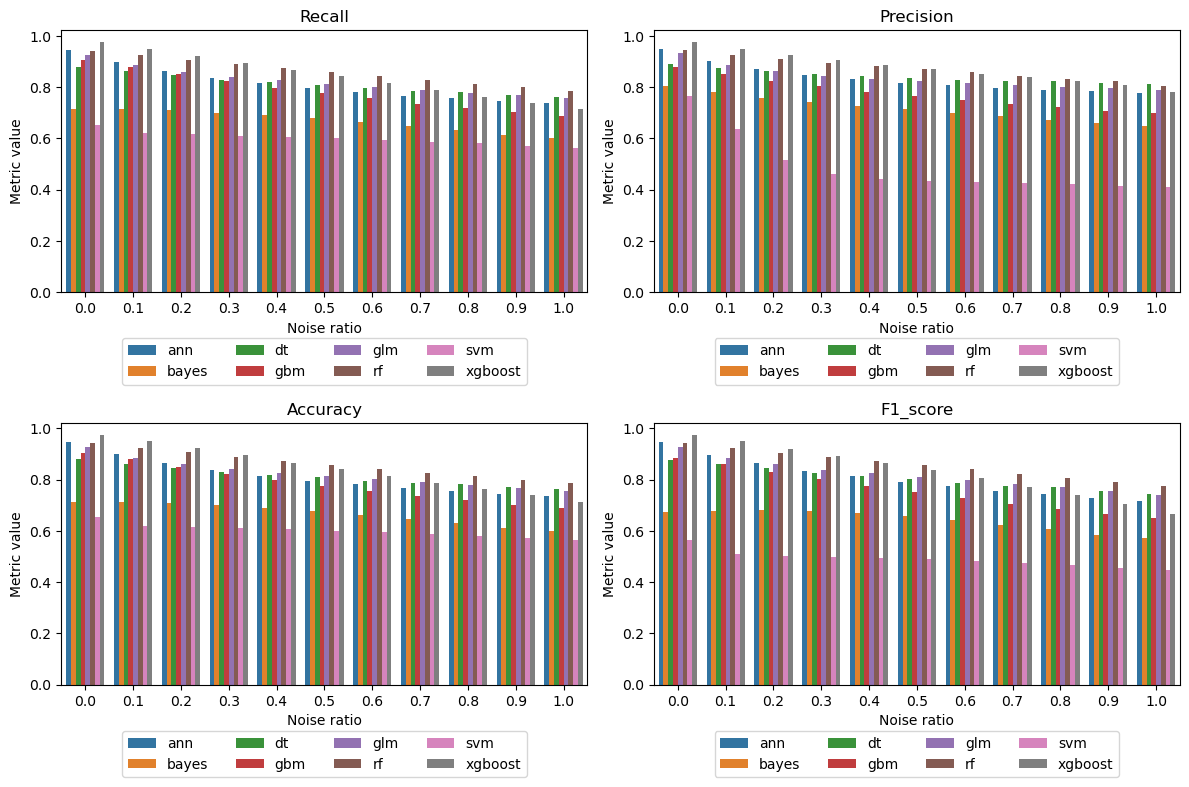

,model,kind,ratio,recall,mcc,accuracy,precision,auc,f1_score,fbeta_score
0,ann,COAP,0.00000000,0.92566194,0.85506283,0.92566194,0.92972618,0.92528043,0.92500789,0.92711577
1,ann,COAP,0.10000000,0.89329605,0.78999365,0.89329605,0.89679786,0.89347383,0.89293736,0.89473030
2,ann,COAP,0.20000000,0.86869920,0.74605534,0.86869920,0.87735498,0.86923703,0.86767267,0.87210565
3,ann,COAP,0.30000000,0.84470084,0.70388831,0.84470084,0.85928504,0.84547344,0.84224226,0.84978451
4,ann,COAP,0.40000000,0.82833042,0.67571376,0.82833042,0.84780574,0.82918040,0.82422143,0.83429274
...,...,...,...,...,...,...,...,...,...,...
259,xgboost,Session,0.60000000,0.71439311,0.50494837,0.71439311,0.79545342,0.71681711,0.69438498,0.73442602
260,xgboost,Session,0.70000000,0.66941598,0.43242575,0.66941598,0.77295213,0.67226751,0.63630709,0.68534080
261,xgboost,Session,0.80000000,0.62192581,0.35026428,0.62192581,0.74659418,0.62521814,0.56949385,0.62341121
262,xgboost,Session,0.90000000,0.57679833,0.26552064,0.57679833,0.72052572,0.58053652,0.49773985,0.54768825


In [368]:
df_tmp = df_result.copy(deep=True)
del df_tmp['attack']
df_tmp = df_tmp.sort_values(by='ratio').reset_index(drop=True)
df_tmp = df_tmp.groupby(['model','kind','ratio']).mean().reset_index()
#模型的平均性能对比
show_line("All",df_tmp,"kind")
#各个模型的性能对比
show_bar("All",df_tmp,"model")
#显示详细
display(df_tmp)